# Lab 2:  Electric Field Mapping

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

# Distance Calibration


In [10]:
# Measured Ruler Distance
length_inches = 7.51
dlength_inches = 0.01
length_cm = 19.0

lcal = length_cm*0.01/length_inches
dlcal = dlength_inches/length_inches*lcal

print ("Ruler calibration: (%0.5f +/- %0.5f) meters/inch" % (lcal,dlcal))

Ruler calibration: (0.02530 +/- 0.00003) meters/inch


# Measurement of Voltage as a function of Position

In [23]:
# Create a Pandas DataFrame with data for part 1

# The data elements are [V, dV, x_inches, dx_inches]

data = [[2.00,0.01,0.34,0.01], [3.00,0.01,0.55,0.01], [4.00,0.01,0.83,0.01], [5.00,0.01,1.08,0.01], 
        [6.00,0.01,1.26,0.01], [7.00,0.01,1.53,0.01], [8.00,0.01,1.75,0.01],
        [9.00,0.01,1.96,0.01], [10.00,0.01,2.18,0.01]]
# create dataframe
df = pd.DataFrame(data, columns = ['V', 'dV','x_inches','dx_inches'])

print(df.to_string(index=False))

    V    dV  x_inches  dx_inches
  2.0  0.01      0.34       0.01
  3.0  0.01      0.55       0.01
  4.0  0.01      0.83       0.01
  5.0  0.01      1.08       0.01
  6.0  0.01      1.26       0.01
  7.0  0.01      1.53       0.01
  8.0  0.01      1.75       0.01
  9.0  0.01      1.96       0.01
 10.0  0.01      2.18       0.01


In [24]:
df['x'] = lcal*df['x_inches']
df['dx'] = df['x']*(df['dx_inches']/df['x_inches']+dlcal/lcal)

print(df.to_string(index=False))

    V    dV  x_inches  dx_inches         x        dx
  2.0  0.01      0.34       0.01  0.008602  0.000264
  3.0  0.01      0.55       0.01  0.013915  0.000272
  4.0  0.01      0.83       0.01  0.020999  0.000281
  5.0  0.01      1.08       0.01  0.027324  0.000289
  6.0  0.01      1.26       0.01  0.031877  0.000295
  7.0  0.01      1.53       0.01  0.038708  0.000305
  8.0  0.01      1.75       0.01  0.044274  0.000312
  9.0  0.01      1.96       0.01  0.049587  0.000319
 10.0  0.01      2.18       0.01  0.055153  0.000326


Beta: [170.41979718   0.50057588]
Beta Std Error: [2.32987325 0.07884126]
Beta Covariance: [[ 1.26963528 -0.03843983]
 [-0.03843983  0.00145386]]
Residual Variance: 4.275487178232718
Inverse Condition #: 0.014882241156085312
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (170.419797180 +/- 2.329873253) X + (0.500575877 +/- 0.078841256)


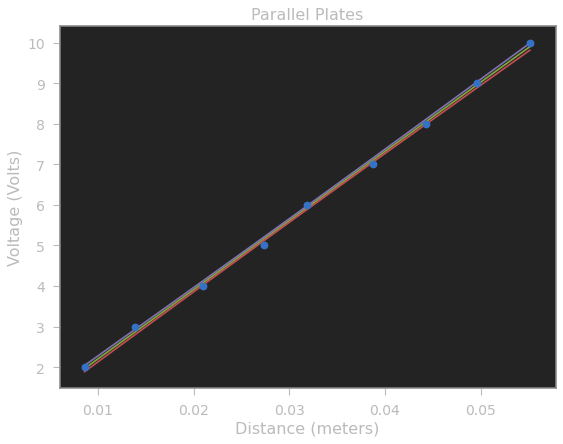

In [25]:
xi = df['x']
yi = df['V']
sigmaxi = df['dx']
sigmayi = df['dV']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[1., 2.]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Distance (meters)')
plt.ylabel('Voltage (Volts)')
plt.title('Parallel Plates')
plt.show()

## Analysis of Voltage vs. Position Result

First of all, we see that this is a pretty good linear fit!

Second, we see that the result for the y-intercept (b) is $(0.501 \pm 0.079)$ Volts.  This is close to zero, but still inconsistent with our expectations.

Third, we see that the average electric field (the slope) that we were trying to determine is
$(170.4 \pm 2.3)$ Volts per meter.  Based on the calculation of the expected value (in the next cell, we are not in agreement with that result.  Why?

In [26]:
# Calculate expected average electric field

total_distance_inches = 2.65
dtotal_distance_inches = 0.01

d = total_distance_inches*lcal
dd = d*(dtotal_distance_inches/total_distance_inches + dlcal/lcal)

V_total = 12.00
dV_total = 0.01

E_avg = V_total/d
dE_avg = E_avg*(dV_total/V_total+dd/d)

print ("Average Electric Field = (%0.1f +/- %0.1f) V/m" % (E_avg,dE_avg))

Average Electric Field = (179.0 +/- 1.1) V/m


Using the code from Part I as a starting point, analyze the data from Part II and III